In [1]:
import matplotlib
import numpy as np
import sys

if '../' not in sys.path:
    sys.path.append('../')

from collections import defaultdict
from lib.envs.blackjack import BlackjackEnv
from lib import plots

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [6]:
def create_random_policy(nA):
    """
    Creates a random policy.
    
    Args:
        nA: Number of acions in the env. (Action Space)
        
    Returns:
        A numpy array with probability of choosing each action.
    """
    
    # create action probability numpy array with 
    # equal probability action assigned to each action
    action_probs = np.ones(nA) / nA
    
    # create policy function
    def policy_fn(observations):
        return action_probs
    
    return policy_fn

In [7]:
def create_target_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # create action prob numpy array
        action_probs = np.zeros(env.action_space.n)
        
        # argmax Q[observation] to fetch the best action
        best_action = np.argmax(Q[observation])
        
        action_probs[best_action] = 1.0
        
        return action_probs

    return policy_fn

In [26]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The cumulative denominator of importance sampling
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_target_policy(Q)
    
    # Implement this!
    # loop through number of episodes
    for episode in range(num_episodes):
        if (episode+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode+1, num_episodes), end="")
            sys.stdout.flush()
        trajectory = []
        
        # get initial state
        state = env.reset()
        for t in range(100):
            # sample action from behavior policy
            action_probs = behavior_policy(state)
            action = np.random.choice(np.arange(env.action_space.n), p=action_probs)
            
            # environment's effect on taking step based on sampled action
            next_state, reward, done, _ = env.step(action)
            
            trajectory.append((state, action, reward))
            
            if done:
                break
            
            state = next_state
        
        # discounted returns sum
        G = 0.0
        
        # importance sampling weight
        W = 1.0
        
        for t in range(len(trajectory))[::-1]:
            state, action, reward = trajectory[t]
            
            # get the returns from this time step
            G += discount_factor * G + reward
            
            # update cumulative denominator for state and action
            C[state][action] += W
            
            # calculate action value
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            
            target_action = np.argmax(target_policy(state))
            
            # If the action taken by the behavior policy is not same as the action 
            # taken by the target policy the probability will be 0 and we can break
            if action != target_action:
                break
                
            W *= 1. / behavior_policy(state)[action]
        
    return Q, target_policy

In [27]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

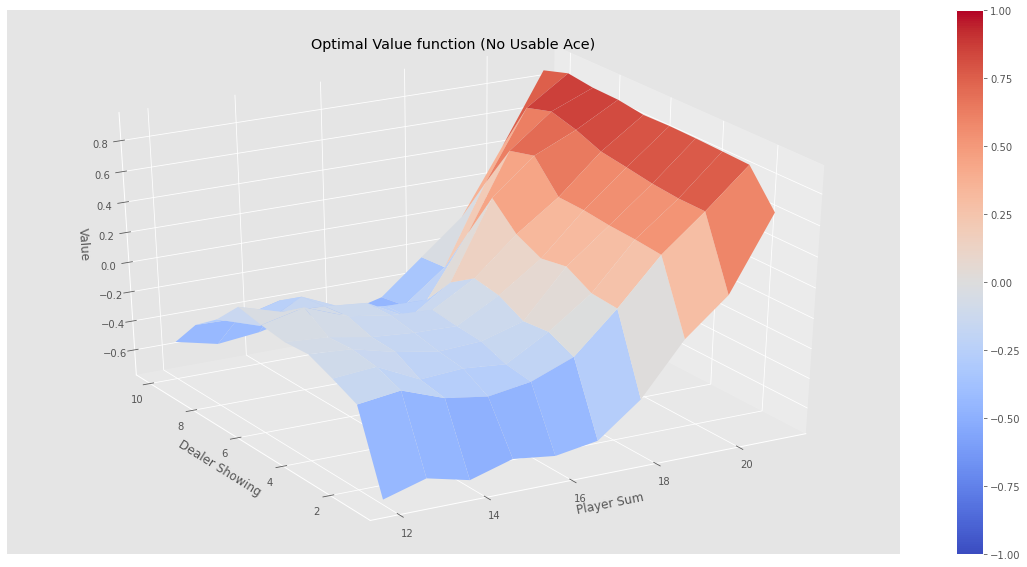

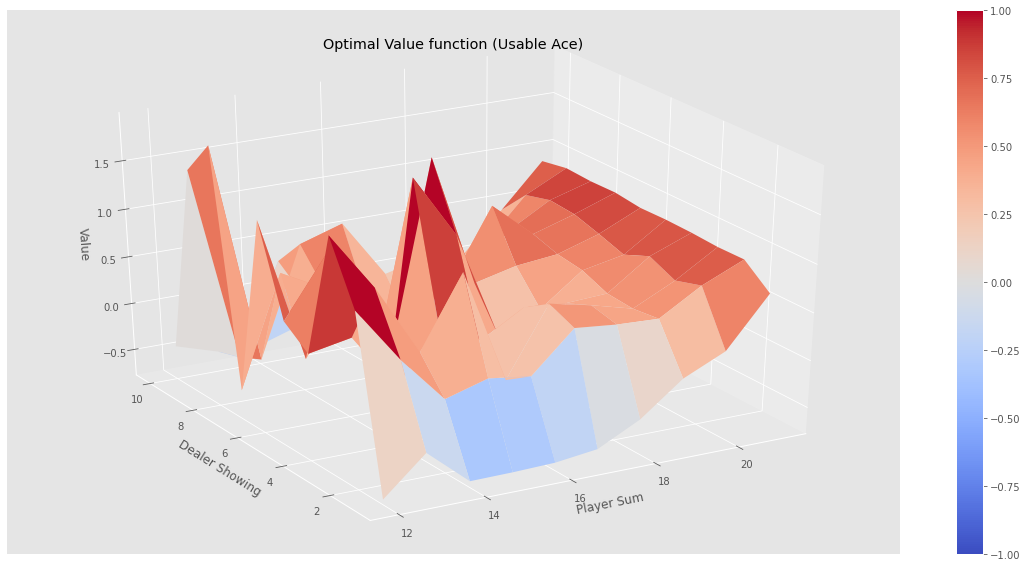

In [29]:
# plot value function
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plots.plot_value_function(V, title="Optimal Value function")